In [15]:
!pip install -q insightface onnxruntime-gpu deepface opencv-python matplotlib pillow

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from deepface import DeepFace
from insightface.app import FaceAnalysis
from google.colab import files
from google.colab.patches import cv2_imshow

In [17]:
face_app = FaceAnalysis(allowed_modules=['detection'])
face_app.prepare(ctx_id=0, det_size=(640, 640))

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition
set det-size: (640, 640)


In [18]:
def get_largest_face_crop(img_path, padding=40):
    img = cv2.imread(img_path)
    faces = face_app.get(img)
    if not faces:
        print("Không tìm thấy gương mặt nào.")
        return None
    largest_face = max(faces, key=lambda f: (f.bbox[2]-f.bbox[0]) * (f.bbox[3]-f.bbox[1]))
    bbox = largest_face.bbox.astype(int)
    x1, y1, x2, y2 = bbox
    h_img, w_img = img.shape[:2]
    x1 = max(0, x1 - padding)
    y1 = max(0, y1 - padding)
    x2 = min(w_img, x2 + padding)
    y2 = min(h_img, y2 + padding)
    cropped_face = img[y1:y2, x1:x2]
    return cropped_face

In [19]:
def analyst_emotion_v2(cropped_img):
    try:
        img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        results = DeepFace.analyze(img_path = cropped_img,
                                   actions = ['emotion'],
                                   enforce_detection = False)
        res = results[0]
        emotion = res['dominant_emotion']
        cv2_imshow(cropped_img)
        print(f"Cảm xúc chủ đạo: {emotion}")
        return results
    except Exception as e:
        print(f"Lỗi phân tích: {e}")
        return None

In [20]:
def plot_bar_chart_emotion(results):
  emotions_data = results[0]['emotion']
  df_plot = pd.DataFrame({
      'Emotion': list(emotions_data.keys()),
      'Percentage': list(emotions_data.values())
  })
  df_plot = df_plot.sort_values(by='Percentage', ascending=False)
  sns.set_theme(style="whitegrid")
  ax = sns.barplot(x='Emotion', y='Percentage', data=df_plot, palette='viridis')
  for p in ax.patches:
      ax.annotate(format(p.get_height(), '.2f') + '%',
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'center',
                  xytext = (0, 9),
                  textcoords = 'offset points')
  plt.title('Phân tích chi tiết tỉ lệ cảm xúc', fontsize=14)
  plt.xlabel('Trạng thái cảm xúc', fontsize=12)
  plt.ylabel('Tỉ lệ (%)', fontsize=12)
  plt.ylim(0, max(df_plot['Percentage']) + 10)
  plt.show()

Saving crying_face.jpg to crying_face.jpg


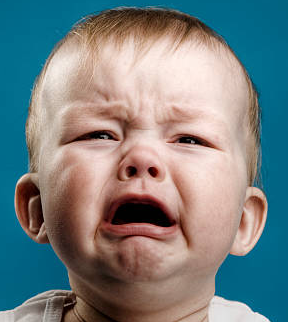

Cảm xúc chủ đạo: fear


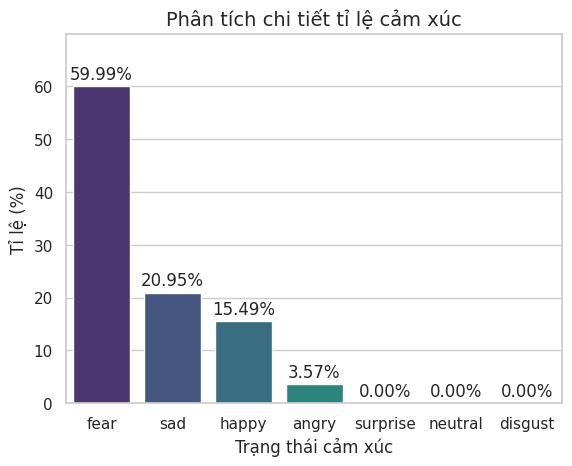

In [21]:
uploaded = files.upload()
if uploaded:
    img_path = list(uploaded.keys())[0]
    cropped_face = get_largest_face_crop(img_path)
    if cropped_face is not None:
        results = analyst_emotion_v2(cropped_face)
        plot_bar_chart_emotion(results)